## Environment setup

In [3]:
import cv2
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from IPython.display import Image
import numpy as np
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import cv2
import colorsys
import random
import numpy as np
import os, random, tensorflow as tf

In [4]:

seed_value=12345
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Tue Mar 11 20:34:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P3              8W /   43W |      24MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!pip install huggingface_hub
import cv2
from ultralytics import YOLO
import supervision as sv


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
current_path = os.getcwd()
HOME = os.path.abspath(os.path.join(current_path, '..'))
print(f"HOME path: {HOME}")

HOME path: d:\CS-KU-01418364-65\DL_project\project


## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [7]:
dataset_location = f"{HOME}\\dataset_plates"

In [8]:
print(dataset_location)

d:\CS-KU-01418364-65\DL_project\project\dataset_plates


In [9]:
# Define the file path
file_path = os.path.join(dataset_location, "data.yaml")

In [10]:
with open(file_path, "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['plates']

roboflow:
  workspace: projectdl-cjfj5
  project: plates_new_dataset
  version: 12
  license: CC BY 4.0
  url: https://universe.roboflow.com/projectdl-cjfj5/plates_new_dataset/dataset/12


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [10]:
model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset_location}/data.yaml',epochs=300,save_period=50)  # ลด batch size


New https://pypi.org/project/ultralytics/8.3.87 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.63  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov12s.yaml, data=c:\Manus\DL_project\project\dataset_plates/data.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=50, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning C:\Manus\DL_project\project\dataset_plates\train\labels.cache... 195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 195/195 [00:00<?, ?it/s]
val: Scanning C:\Manus\DL_project\project\dataset_plates\valid\labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/13 [00:00<?, ?it/s]UserWarning: Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\attention_backward.cu:657.)
      1/300      4.91G       6.27      39.74      3.803         55        640: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         19        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      4.92G       6.97      37.23      4.139         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         19        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      4.91G       6.29      9.685      3.682         47        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         19        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      5.02G      4.494      2.839      3.166         67        640: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      5.05G      4.088       2.24       2.91         23        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         19        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300       4.9G      3.734      1.844      2.597         29        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         19        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      4.87G      3.315      1.629      2.423         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         19        170          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300       4.9G      3.298      1.599      2.338         62        640: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         19        170    0.00596        0.2     0.0356     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      4.86G      3.088      1.565      2.319         23        640: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         19        170      0.187      0.376      0.184     0.0578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      4.91G      3.007      1.523       2.28         54        640: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         19        170      0.258      0.541      0.318     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      4.94G      3.037      1.499      2.292         69        640: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         19        170      0.346      0.653      0.392      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      4.93G      2.911      1.478      2.222         64        640: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19        170      0.359      0.565      0.417      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      4.86G      2.888      1.421      2.211         65        640: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         19        170      0.365      0.541      0.369      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      4.92G      3.014      1.396      2.265         23        640: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19        170      0.516      0.689      0.598      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      4.91G      2.937      1.402      2.215         42        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         19        170      0.509      0.688      0.585      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      4.89G      2.846      1.448      2.187         24        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         19        170      0.527      0.661      0.594      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      4.88G       2.71      1.344      2.154         38        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         19        170      0.556      0.606      0.625      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      4.85G      2.753      1.352      2.189         24        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         19        170      0.627      0.653      0.669      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      4.91G       2.66       1.31      2.137         59        640: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         19        170      0.634      0.706      0.659      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      5.07G      2.632      1.348      2.079         51        640: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19        170      0.603      0.365      0.439      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      4.89G      2.521      1.278      2.062         25        640: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19        170      0.234      0.265      0.136     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      4.92G      2.671       1.29      2.066         18        640: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         19        170      0.548      0.153      0.133     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      4.93G      2.667      1.296      2.072         19        640: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         19        170      0.542      0.576      0.496      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      4.98G      2.647      1.297      2.027         49        640: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         19        170      0.624      0.429       0.53      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      5.01G      2.542       1.31      1.954         29        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         19        170      0.651      0.635      0.671       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      4.96G      2.517      1.227      1.993         68        640: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         19        170       0.84      0.547      0.675      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      4.91G      2.421      1.201       1.99         25        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         19        170      0.827      0.676      0.804      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      4.92G      2.453      1.202      1.982         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19        170      0.564      0.735      0.615      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300       4.9G      2.442      1.232      1.999         53        640: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         19        170      0.792      0.716       0.78      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      4.91G      2.403      1.198      1.926         32        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         19        170        0.8      0.771      0.845      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300       5.1G      2.342      1.137      1.952         78        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         19        170      0.833      0.735       0.85      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      4.93G      2.323      1.162      1.952         31        640: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         19        170      0.838      0.794      0.887      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      4.96G      2.396      1.162      1.933         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         19        170      0.803      0.767      0.848       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300       4.9G      2.314      1.144      1.915         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         19        170      0.827      0.757      0.843      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      4.89G      2.382      1.159      1.894         83        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         19        170      0.762      0.752      0.788      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      4.96G      2.301      1.138      1.889         47        640: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19        170      0.848      0.676      0.804      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      4.91G      2.397      1.172       1.94         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         19        170      0.857      0.773      0.879      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      4.91G      2.392      1.147        1.9         53        640: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         19        170      0.873      0.794      0.868      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      4.95G      2.362      1.117      1.913         51        640: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         19        170      0.843      0.823      0.894      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      4.88G      2.307      1.126      1.886         37        640: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         19        170      0.865      0.676      0.811      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      4.89G      2.306      1.118      1.893         77        640: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         19        170      0.868      0.776      0.878      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      4.91G      2.343      1.138      1.888         24        640: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         19        170      0.909      0.771       0.91      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300       4.9G      2.365      1.149      1.873         48        640: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         19        170      0.852      0.759      0.854      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300       4.9G      2.268      1.119       1.88         47        640: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         19        170      0.862      0.776      0.883      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      4.85G      2.318      1.136      1.867         69        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         19        170      0.847      0.752      0.879       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      4.97G      2.335      1.139      1.872         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         19        170      0.889      0.753      0.877      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      4.98G      2.305      1.154      1.894          6        640: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         19        170      0.851      0.807      0.901      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      4.88G      2.284      1.124      1.892         19        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         19        170      0.925      0.729      0.894      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300       4.8G      2.282        1.1       1.87         23        640: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         19        170      0.932      0.804      0.922      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300       4.9G      2.192      1.093      1.833         59        640: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         19        170      0.917      0.776      0.918      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      4.94G      2.163      1.064        1.8         28        640: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         19        170      0.919      0.797        0.9      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      4.95G      2.139      1.043      1.833         12        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         19        170      0.886      0.824      0.925      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      4.85G      2.141      1.068      1.825         32        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         19        170      0.895      0.799      0.909       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      4.92G      2.261      1.076      1.848         79        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         19        170      0.783      0.835      0.859      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      4.91G      2.268      1.086      1.847         71        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         19        170      0.906      0.724      0.908       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      4.91G      2.254      1.134      1.855         50        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         19        170      0.961      0.727      0.894      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      4.88G      2.201      1.111      1.842         21        640: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         19        170      0.844      0.818      0.908      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      4.94G      2.156      1.087       1.82         53        640: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         19        170      0.923      0.845      0.926      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      4.93G      2.163      1.098      1.833         83        640: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         19        170      0.823      0.835      0.904      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      4.94G      2.153      1.071      1.821         51        640: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19        170      0.907      0.835      0.919      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      4.87G      2.139      1.049      1.792         79        640: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         19        170       0.87      0.825      0.898      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      4.91G      2.168      1.072      1.809         27        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         19        170      0.918      0.858      0.926      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      4.96G      2.188      1.096       1.82         33        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         19        170      0.896      0.865      0.939      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      4.88G       2.09      1.041       1.79         46        640: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         19        170       0.91      0.765      0.872      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      4.91G      2.242      1.075      1.791         53        640: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         19        170       0.88      0.777      0.883      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      4.84G      2.171      1.058      1.796         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         19        170       0.93      0.863      0.932      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      4.94G      2.281        1.1      1.866         26        640: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         19        170      0.942      0.859      0.936       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      5.08G      2.199      1.108      1.818         21        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         19        170      0.933      0.776      0.905      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      4.87G      2.203      1.112      1.763         23        640: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         19        170      0.916      0.765      0.916      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      4.92G      2.168       1.07      1.813         42        640: 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         19        170      0.906      0.776      0.916      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      4.89G      2.225      1.068      1.802         72        640: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         19        170      0.907      0.805      0.914       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      4.89G      2.129       1.06      1.796         38        640: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         19        170      0.901      0.804      0.915      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      4.87G      2.192      1.039      1.814         32        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         19        170      0.911       0.84      0.928       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300       4.9G      2.087      1.021      1.795         43        640: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         19        170      0.889      0.852      0.933      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      4.95G      2.101      1.055        1.8         31        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         19        170      0.913      0.864      0.927      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      4.93G      2.108       1.04      1.765         18        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         19        170      0.921      0.829      0.923      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      4.91G      2.078      1.079      1.768         38        640: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         19        170      0.898      0.829       0.92      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      4.83G      2.034      1.014      1.766         42        640: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         19        170      0.935      0.812      0.922      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      4.91G      2.063      1.018      1.756         44        640: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         19        170      0.952      0.841      0.933      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      4.91G      2.027      1.007       1.74         62        640: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         19        170      0.893      0.834      0.928      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      4.87G      2.028      1.029      1.781         14        640: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         19        170      0.899      0.847      0.925      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      4.92G       2.11      1.015      1.762         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         19        170      0.884      0.854      0.926      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      4.89G      2.072       1.03      1.793         27        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         19        170      0.878      0.829      0.919       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      4.91G      2.109      1.016      1.777         59        640: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         19        170      0.876      0.865      0.925      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      4.94G      2.066      1.027      1.756         15        640: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19        170      0.882      0.871      0.937      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      4.93G      2.024      1.056      1.748         27        640: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         19        170      0.879      0.815      0.897      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      4.89G      2.016      1.015      1.735         44        640: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         19        170      0.894      0.794      0.908       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      4.88G      2.027      1.005      1.727         47        640: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         19        170      0.873      0.859      0.934      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      4.92G      1.962     0.9697      1.685         29        640: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         19        170      0.926      0.841      0.928      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      4.92G      1.967       0.99      1.712         24        640: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         19        170      0.913      0.847      0.933      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      4.98G       1.98     0.9914      1.732         38        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         19        170      0.937      0.871       0.94       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      4.95G      2.005     0.9845      1.728         46        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         19        170      0.966      0.859      0.948      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      4.89G      2.016     0.9998      1.734         36        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         19        170      0.954      0.818      0.935      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      4.89G      2.044      1.002      1.745         41        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         19        170      0.892      0.847      0.928      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      4.91G      1.995      1.004      1.682         68        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         19        170      0.958      0.829      0.944      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      4.95G      1.945     0.9633      1.675         56        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         19        170      0.942      0.871      0.944      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      4.87G      1.991     0.9962      1.727         37        640: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         19        170      0.909      0.878      0.938      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      4.94G      2.005     0.9636      1.701         54        640: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         19        170      0.886      0.853      0.938      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      4.91G      1.968     0.9957      1.697         83        640: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         19        170       0.89      0.835      0.931      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300       4.9G      1.907      0.982      1.702         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         19        170      0.914      0.853      0.937      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      5.01G      1.921     0.9495      1.657         31        640: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         19        170      0.962      0.847      0.947      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      4.94G      1.913     0.9312      1.659         58        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         19        170      0.965       0.82      0.943      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      4.91G      1.959     0.9529      1.655         68        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         19        170      0.952      0.823      0.928      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      4.89G      1.996     0.9424      1.706         84        640: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         19        170      0.927      0.827      0.941      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      4.88G      2.017      0.936      1.766         27        640: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         19        170      0.924      0.853      0.934      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      4.91G      2.161     0.9924      1.864         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         19        170      0.879      0.841      0.921      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300       4.9G      2.003     0.9816        1.7         40        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         19        170      0.906      0.835      0.907      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      4.92G      1.959     0.9446      1.671         75        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         19        170      0.911      0.871      0.929       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      4.91G      1.881     0.9388      1.652         40        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         19        170       0.93      0.862      0.932      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      4.92G      1.908     0.9376      1.652         27        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19        170      0.938      0.865      0.929      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      4.91G      1.917      0.949      1.674         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         19        170      0.917      0.844      0.926      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      4.91G      1.914     0.9398      1.658         52        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         19        170      0.927      0.825      0.916      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      4.85G      1.906     0.9172      1.643         25        640: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         19        170      0.929      0.852      0.938      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      4.92G      1.976     0.9485      1.669         29        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         19        170      0.925      0.871      0.936       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      5.09G      1.877     0.9223      1.635         39        640: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         19        170      0.979        0.9      0.962      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      4.94G      1.824     0.9158      1.615         50        640: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         19        170      0.955      0.879      0.949      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      4.86G      1.848     0.9183       1.65         30        640: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19        170      0.934      0.859      0.941      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      4.94G      1.836     0.9024       1.61         53        640: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         19        170      0.932      0.885      0.952      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      4.94G      1.792     0.8985      1.612         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         19        170      0.932      0.887      0.958      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300       4.9G      1.853     0.8919      1.621         55        640: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         19        170      0.923       0.85      0.925      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      5.06G      1.895     0.9196      1.664         60        640: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         19        170      0.952      0.806      0.924      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      5.12G      1.886     0.9057      1.647         29        640: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         19        170      0.922      0.835      0.919      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      4.89G      1.856     0.9113      1.622         61        640: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         19        170      0.952      0.853      0.951      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      4.91G      1.862     0.9096      1.683         25        640: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         19        170      0.865        0.9      0.922      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      4.85G      1.859     0.9006      1.641         88        640: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19        170      0.961      0.867      0.949      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      4.95G      1.887     0.9205      1.645         43        640: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19        170      0.901      0.888      0.928      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      4.93G      1.852     0.8838      1.618         46        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         19        170      0.902      0.868      0.921      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      4.92G      1.808      0.881       1.61         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         19        170      0.961       0.88       0.96      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      4.89G      1.827     0.8903      1.616         29        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         19        170       0.95      0.897      0.951       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      4.87G      1.839     0.8725      1.615         68        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         19        170      0.974      0.871      0.959      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      4.89G      1.849     0.8816      1.659         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         19        170       0.95      0.895      0.958      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      4.91G      1.787      0.867      1.615         39        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         19        170      0.949      0.912      0.959      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      4.86G      1.757     0.8315      1.543         50        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         19        170      0.938      0.912      0.962      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      4.92G      1.784      0.885      1.566         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         19        170      0.936      0.906      0.953       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      4.94G      1.773     0.8632       1.58         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         19        170      0.936      0.862      0.928      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      4.87G      1.713     0.8544      1.569         38        640: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         19        170      0.933      0.876      0.945      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      4.85G      1.764     0.8383      1.596         31        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         19        170       0.94      0.906      0.948      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      4.92G      1.739     0.8496      1.585         36        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         19        170      0.965      0.894       0.96      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      4.93G      1.753     0.8413      1.574         64        640: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         19        170      0.967      0.906      0.961      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      4.92G      1.744     0.8467      1.572         23        640: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         19        170      0.957      0.882      0.964      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      4.87G      1.721     0.8715      1.591         40        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         19        170      0.931      0.879      0.962       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300       4.9G      1.737     0.8378      1.556         76        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         19        170      0.944      0.891      0.956      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      4.93G      1.753     0.8555      1.581         60        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         19        170      0.961      0.868      0.962      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      4.95G       1.73     0.8435      1.545         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         19        170      0.948      0.894      0.953      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      4.87G      1.746      0.855      1.557         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         19        170      0.973      0.859      0.956      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      4.91G      1.788     0.8687       1.61         51        640: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19        170      0.961      0.869      0.963      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      4.89G      1.887     0.8809      1.664         26        640: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         19        170      0.882      0.877      0.923      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      4.91G      1.773     0.8319      1.598         46        640: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19        170      0.956      0.889      0.958      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      4.91G      1.766      0.871       1.58         18        640: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         19        170      0.915      0.882      0.932      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      4.87G      1.727     0.8442      1.557         22        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         19        170      0.967      0.865       0.96      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      4.87G      1.705     0.8235      1.572         27        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         19        170      0.942      0.859      0.944      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      4.93G      1.752     0.8507      1.553         40        640: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         19        170      0.956      0.865      0.951      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      4.93G       1.74     0.8557      1.561         34        640: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         19        170      0.924      0.862      0.942      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      4.91G      1.726     0.8138      1.568         29        640: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         19        170      0.925      0.847      0.947      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300       4.9G      1.809     0.8548      1.557         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         19        170      0.901      0.861      0.934      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      4.91G       1.71     0.8261      1.553         34        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         19        170       0.96      0.838      0.939      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      4.91G      1.781     0.8286      1.573         61        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         19        170      0.933      0.924      0.966      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300       4.9G      1.774     0.8339      1.569         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         19        170      0.918      0.925       0.96       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      4.88G      1.704     0.8165      1.564         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         19        170      0.902      0.922      0.945      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      4.89G      1.734     0.8511      1.552         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         19        170      0.882      0.926      0.962      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      4.91G      1.674     0.8055      1.536         27        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         19        170      0.915      0.876       0.96      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      4.95G      1.719      0.804       1.56         79        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         19        170      0.939      0.876      0.955      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      4.89G       1.72     0.8187      1.548         88        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         19        170       0.94      0.882       0.96      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      4.94G      1.722     0.8224      1.559         34        640: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         19        170      0.962      0.886       0.97      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      4.87G      1.741     0.8113      1.593         32        640: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all         19        170       0.97      0.859      0.964       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      4.89G      1.722     0.8096      1.513         18        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         19        170      0.955      0.875      0.956      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      4.94G      1.704     0.8401      1.518         45        640: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         19        170      0.968      0.883      0.958       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      4.91G       1.69     0.8056      1.522         20        640: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         19        170      0.962      0.882      0.961      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      4.88G      1.682     0.7962      1.501         52        640: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         19        170      0.974        0.9       0.97      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      4.92G      1.666      0.786      1.534         13        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19        170      0.955        0.9      0.964      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      4.89G      1.615     0.7716      1.534         17        640: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19        170      0.948        0.9      0.969      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      4.89G      1.642     0.7738      1.497         87        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         19        170      0.966      0.871      0.954      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      5.02G       1.61      0.774      1.491         81        640: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         19        170      0.967      0.871      0.961      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      4.92G      1.615     0.7632      1.485         76        640: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         19        170      0.967      0.872      0.955      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      4.91G      1.683     0.7749      1.504         38        640: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         19        170      0.933      0.905      0.956      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300       4.9G      1.684     0.7881      1.501         42        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         19        170      0.939      0.912      0.962      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      4.93G      1.616     0.7654      1.494         58        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         19        170      0.939      0.924      0.959      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300       5.1G      1.642     0.7729      1.496         25        640: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         19        170      0.935      0.882      0.964      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      4.89G      1.614     0.7665      1.486         68        640: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         19        170      0.938      0.912      0.966      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300       4.9G      1.591     0.7612      1.482         47        640: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         19        170      0.925      0.869      0.955      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      4.95G      1.657     0.7975      1.519         17        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         19        170      0.919      0.888      0.963      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300       4.9G      1.644     0.7676      1.498         35        640: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         19        170      0.945      0.924      0.966      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      4.88G      1.674     0.7805      1.526         55        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         19        170      0.938      0.888      0.961      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      4.94G      1.685     0.8047        1.5         27        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         19        170      0.959      0.876      0.962      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      4.97G      1.672     0.7856      1.526         25        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         19        170      0.977      0.871      0.962      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      4.91G      1.655     0.7697      1.494         58        640: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         19        170      0.937      0.859      0.956      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      4.93G      1.652     0.7632      1.473         49        640: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         19        170      0.932        0.9      0.961      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      4.91G      1.663     0.7779      1.488         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19        170      0.975      0.871      0.972      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      4.87G      1.646     0.7836      1.491         60        640: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         19        170       0.94      0.917      0.972      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      4.91G      1.631     0.7768      1.479         33        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         19        170      0.912      0.906      0.961      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      4.91G      1.602     0.7368      1.479         90        640: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         19        170      0.938      0.893      0.964      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      4.92G      1.609      0.758      1.486         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         19        170      0.963      0.908      0.975      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      4.87G      1.595     0.7394      1.474         35        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19        170      0.963      0.912      0.979       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      4.93G      1.589     0.7425      1.459         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         19        170      0.962      0.905      0.967      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      4.94G      1.562      0.753      1.461         40        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         19        170       0.93      0.912      0.966      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      4.91G      1.622      0.757      1.482         37        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         19        170      0.925      0.918      0.958      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      4.93G      1.616     0.7607      1.475         57        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         19        170      0.962      0.892      0.964      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      4.92G      1.625     0.7571      1.489         71        640: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         19        170      0.961      0.847      0.962      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      4.93G      1.608     0.7479       1.48         67        640: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         19        170      0.904      0.891      0.964        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      4.92G      1.606     0.7492      1.484         24        640: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         19        170      0.947        0.9      0.966      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      4.85G      1.588     0.7616      1.503         35        640: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         19        170      0.974      0.893      0.973      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      4.92G      1.609     0.7448      1.487         48        640: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         19        170      0.967      0.894      0.968      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      4.82G       1.63     0.7602      1.498         36        640: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         19        170      0.941      0.918       0.97      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      4.93G      1.596     0.7638      1.457         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         19        170      0.928      0.882       0.96      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      4.87G       1.56     0.7414      1.447         28        640: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         19        170      0.925      0.894      0.961      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      4.91G      1.592     0.7462      1.472         26        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         19        170      0.951      0.859      0.947       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      4.91G      1.564      0.736      1.451         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         19        170      0.938      0.853      0.943       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      4.92G      1.594     0.7554      1.446         76        640: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         19        170      0.961      0.864      0.963       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      4.96G      1.622     0.7726      1.453         16        640: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19        170      0.956      0.859      0.945      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      4.95G      1.611     0.7708      1.466         42        640: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         19        170      0.895      0.902      0.952      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      4.91G      1.604     0.7302      1.454         85        640: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         19        170       0.95      0.876      0.957      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300       4.9G      1.598     0.7529      1.447         86        640: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19        170      0.947      0.882      0.952      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300       4.9G       1.56     0.7414      1.433         22        640: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         19        170      0.942      0.862      0.957      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      4.93G      1.616     0.7533      1.473         38        640: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         19        170      0.955      0.871      0.961      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      4.96G      1.578     0.7572      1.443         18        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         19        170      0.942      0.876      0.962      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      4.87G      1.537       0.73      1.438         81        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         19        170      0.909      0.935      0.971      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      4.85G      1.527     0.7274      1.419         78        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         19        170      0.945      0.905      0.969      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      4.95G      1.545     0.7366       1.43         59        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         19        170      0.966      0.865      0.946      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300       4.9G      1.546     0.7342      1.432         46        640: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         19        170      0.915      0.891      0.946      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      4.92G      1.532     0.7229      1.433         42        640: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         19        170      0.943      0.881      0.958      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      4.99G      1.518     0.7324      1.411         26        640: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         19        170       0.94      0.894      0.971       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      5.06G      1.511     0.7131      1.412         37        640: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         19        170      0.927       0.89      0.957      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300       4.9G      1.578     0.7282      1.434         53        640: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         19        170      0.939      0.859      0.948      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      4.86G       1.52     0.7237      1.423         50        640: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         19        170      0.963      0.847      0.953      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      4.86G       1.52      0.723      1.437         57        640: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         19        170      0.987      0.868      0.956      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      5.09G      1.581     0.7345      1.403         70        640: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         19        170      0.933      0.907      0.947      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      5.08G      1.547     0.7109      1.446         16        640: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         19        170      0.945      0.912      0.965      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      5.03G      1.545      0.743      1.438         52        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         19        170      0.964      0.888      0.964      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      4.92G      1.559     0.7283      1.421        108        640: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         19        170      0.948       0.86      0.948      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      4.94G      1.521     0.7385      1.398         18        640: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         19        170      0.952      0.876      0.957      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      5.08G      1.548     0.7286      1.416         48        640: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         19        170      0.961      0.872      0.963      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      4.88G      1.556     0.7309      1.418         68        640: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         19        170      0.972      0.865      0.965      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      4.93G      1.521     0.7001      1.408         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         19        170       0.94      0.876      0.955      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      4.95G      1.516     0.7091        1.4         59        640: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         19        170      0.937      0.865      0.961      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      4.89G      1.539     0.7107      1.417         47        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         19        170      0.958      0.865      0.966      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      5.08G      1.507     0.7141       1.42         24        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         19        170      0.974      0.871      0.965      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      4.91G      1.532     0.7168      1.414         46        640: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         19        170       0.95        0.9      0.971      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300       4.9G      1.528     0.7321      1.391         17        640: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         19        170       0.94      0.906      0.966      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      4.89G      1.521     0.7135        1.4         35        640: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         19        170      0.975      0.912      0.968      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      4.89G       1.54     0.7229      1.429         43        640: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         19        170      0.968      0.893      0.969      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300       4.9G      1.492     0.7014      1.385         36        640: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         19        170      0.961      0.882       0.97      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      4.95G       1.52     0.6999      1.378         71        640: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19        170      0.966      0.894      0.971      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      4.95G      1.482     0.7124      1.381         61        640: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all         19        170      0.966      0.906      0.973      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      4.89G      1.475     0.6966      1.391         34        640: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         19        170       0.96      0.894      0.968       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      4.86G      1.517     0.7082      1.382         39        640: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         19        170      0.963      0.876      0.967      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      4.92G      1.495     0.6994      1.413         45        640: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19        170      0.961      0.888      0.968      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      4.89G      1.536     0.7099      1.409         56        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         19        170      0.976      0.882      0.975      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      4.87G      1.458     0.6976      1.378         51        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         19        170      0.988      0.894       0.98      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      4.88G       1.47     0.7484      1.381         15        640: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         19        170      0.969      0.922      0.981      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      4.94G      1.448     0.6831      1.367         74        640: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         19        170      0.956        0.9      0.973      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      4.97G      1.479      0.707        1.4         49        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         19        170      0.951      0.906      0.965      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      5.08G      1.486     0.6869      1.371         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         19        170      0.938      0.912       0.96      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      4.87G      1.487     0.6932      1.385         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         19        170      0.935        0.9      0.958      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      4.92G      1.535     0.7286      1.423         11        640: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         19        170       0.92      0.918      0.957       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      4.93G      1.503     0.7181      1.421         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         19        170      0.963      0.911      0.974      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      4.94G      1.447     0.7051      1.359         68        640: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19        170      0.967      0.894      0.978      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      5.02G      1.471     0.7037      1.376         28        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19        170      0.976      0.888      0.967      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      4.91G      1.485     0.7154      1.399         53        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         19        170      0.937      0.894      0.965      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      4.94G      1.462     0.6909      1.367         48        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         19        170      0.938      0.889      0.961       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      4.89G      1.578     0.7251       1.44         25        640: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         19        170      0.911        0.9       0.96      0.461
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 160, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



260 epochs completed in 0.635 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 19.0MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 19.0MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.63  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLOv12s summary (fused): 352 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


                   all         19        170      0.893      0.881       0.96      0.504
Speed: 0.4ms preprocess, 7.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train3


## Evaluate fine-tuned YOLOv12 model

In [11]:
from IPython.display import Image

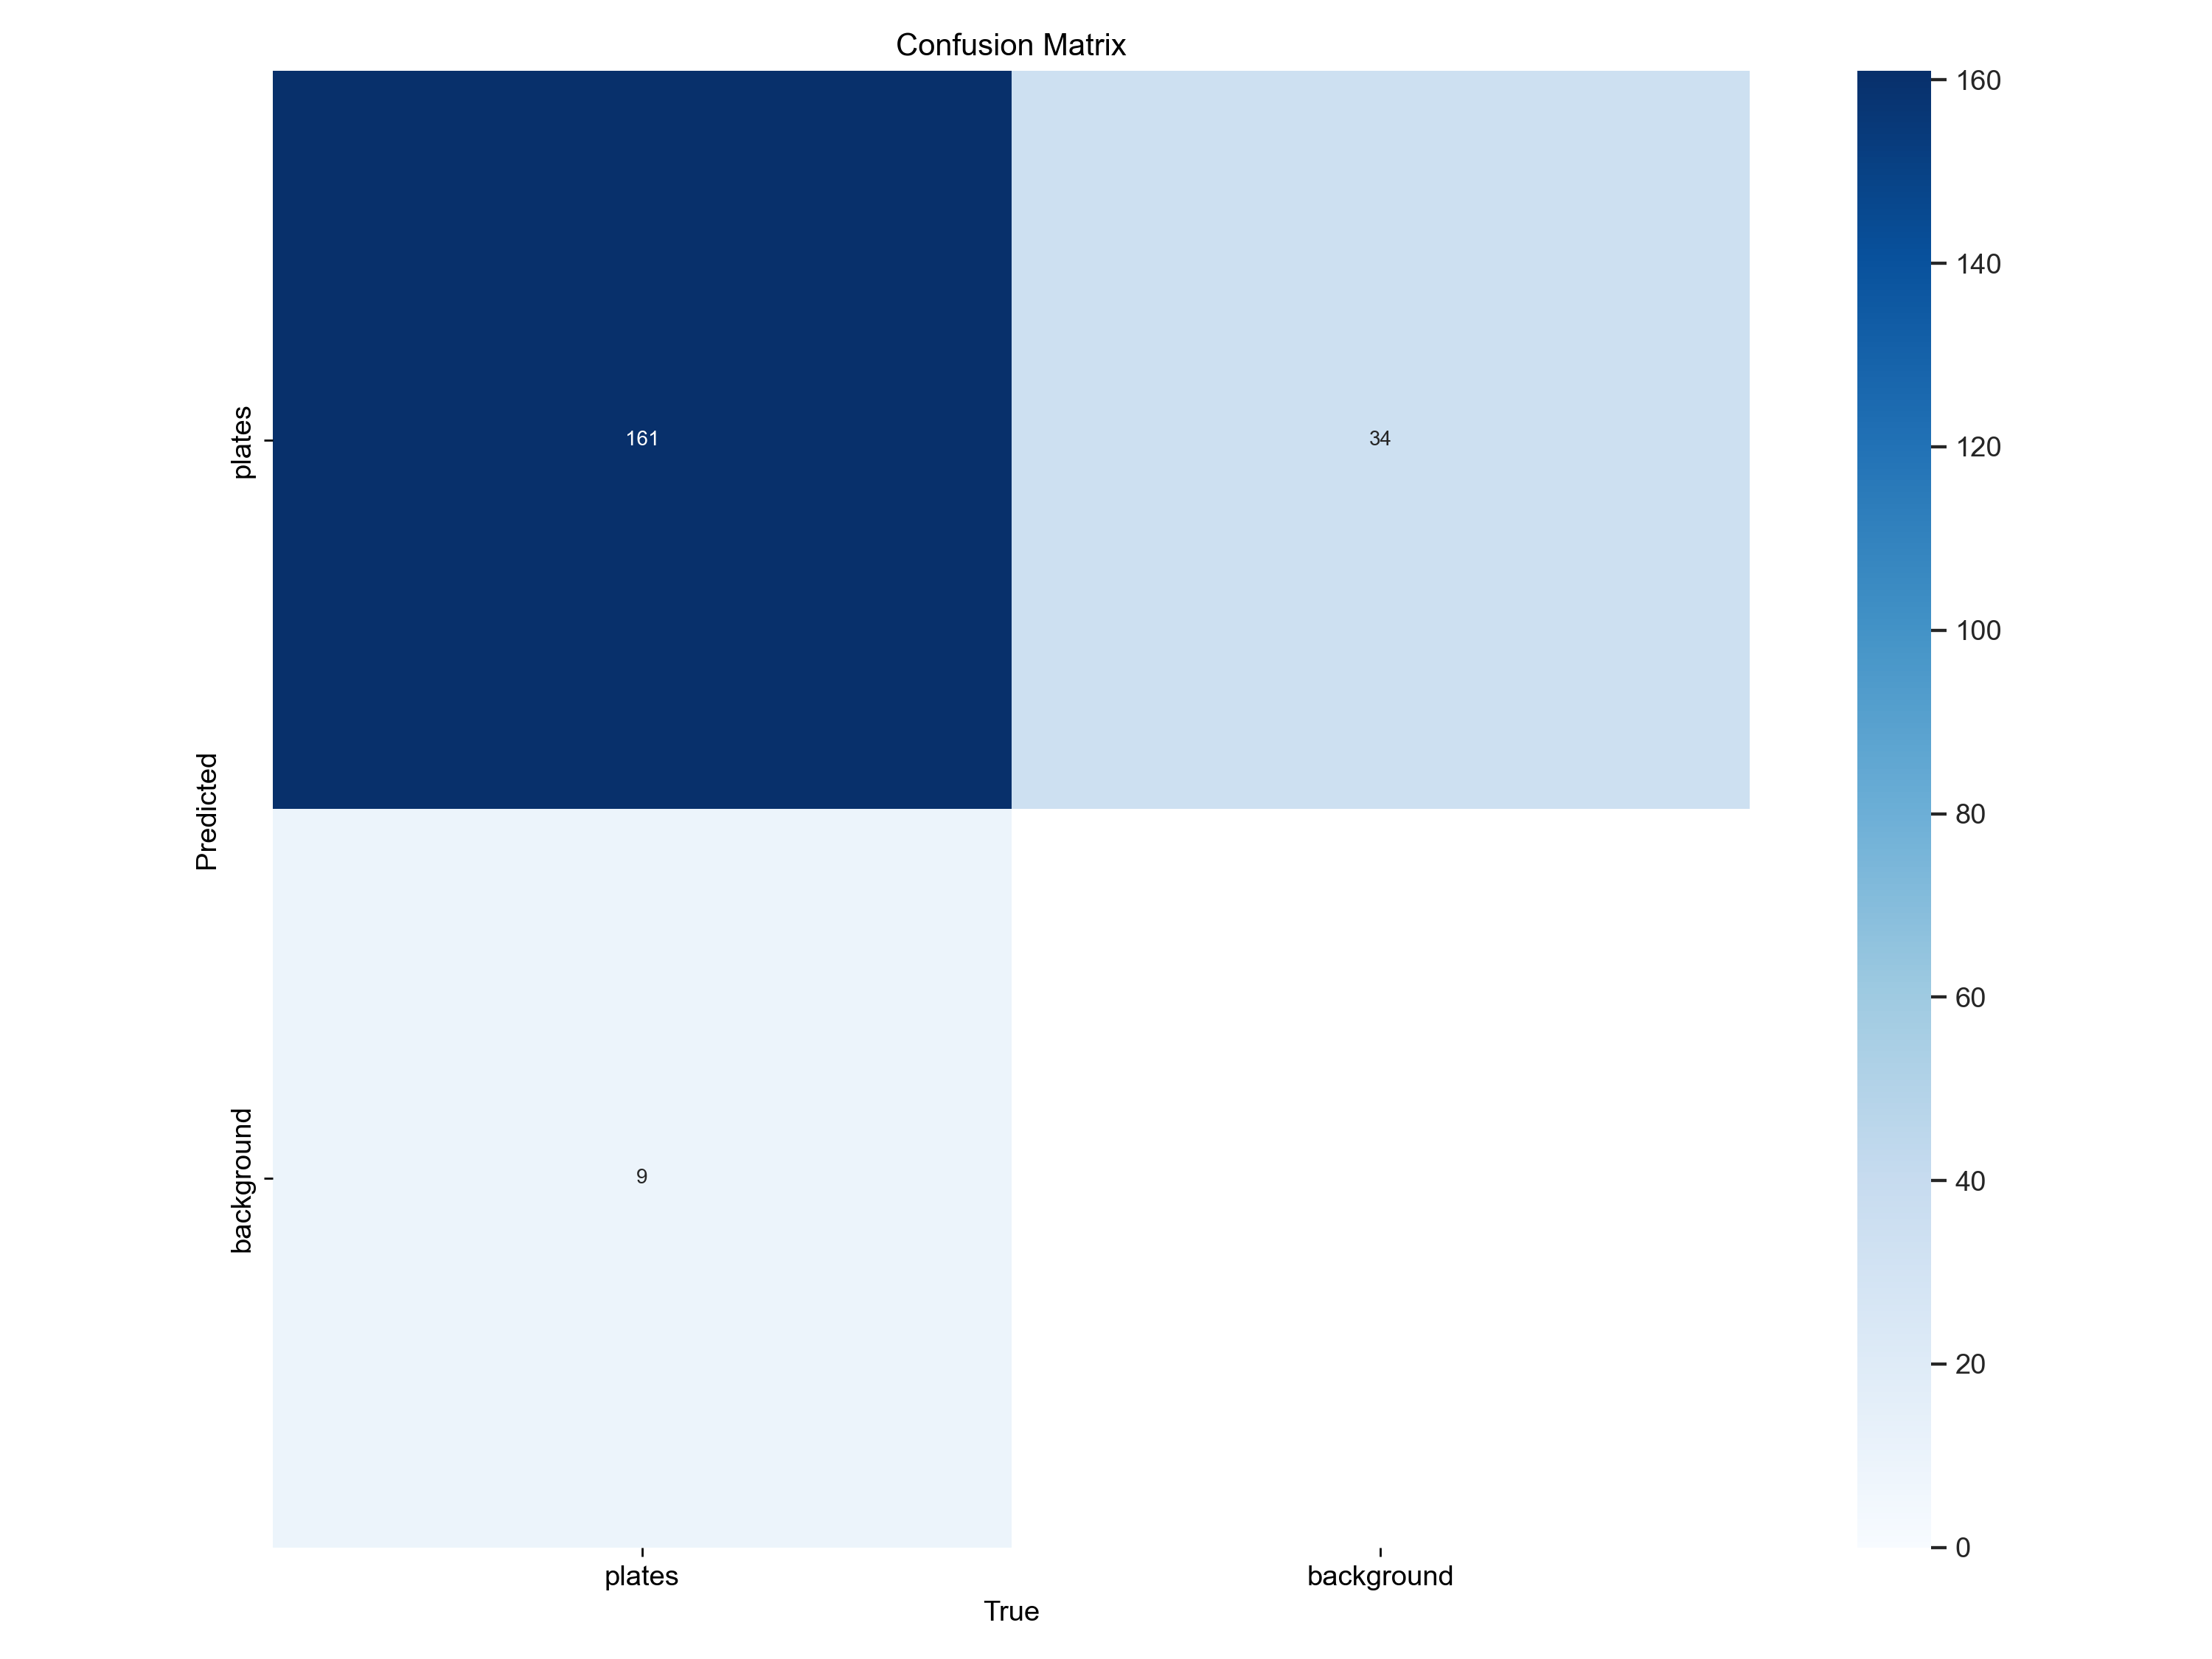

In [12]:
Image(filename=f"{HOME}\\train_model\\runs\\detect\\train\\confusion_matrix.png", width=1000)

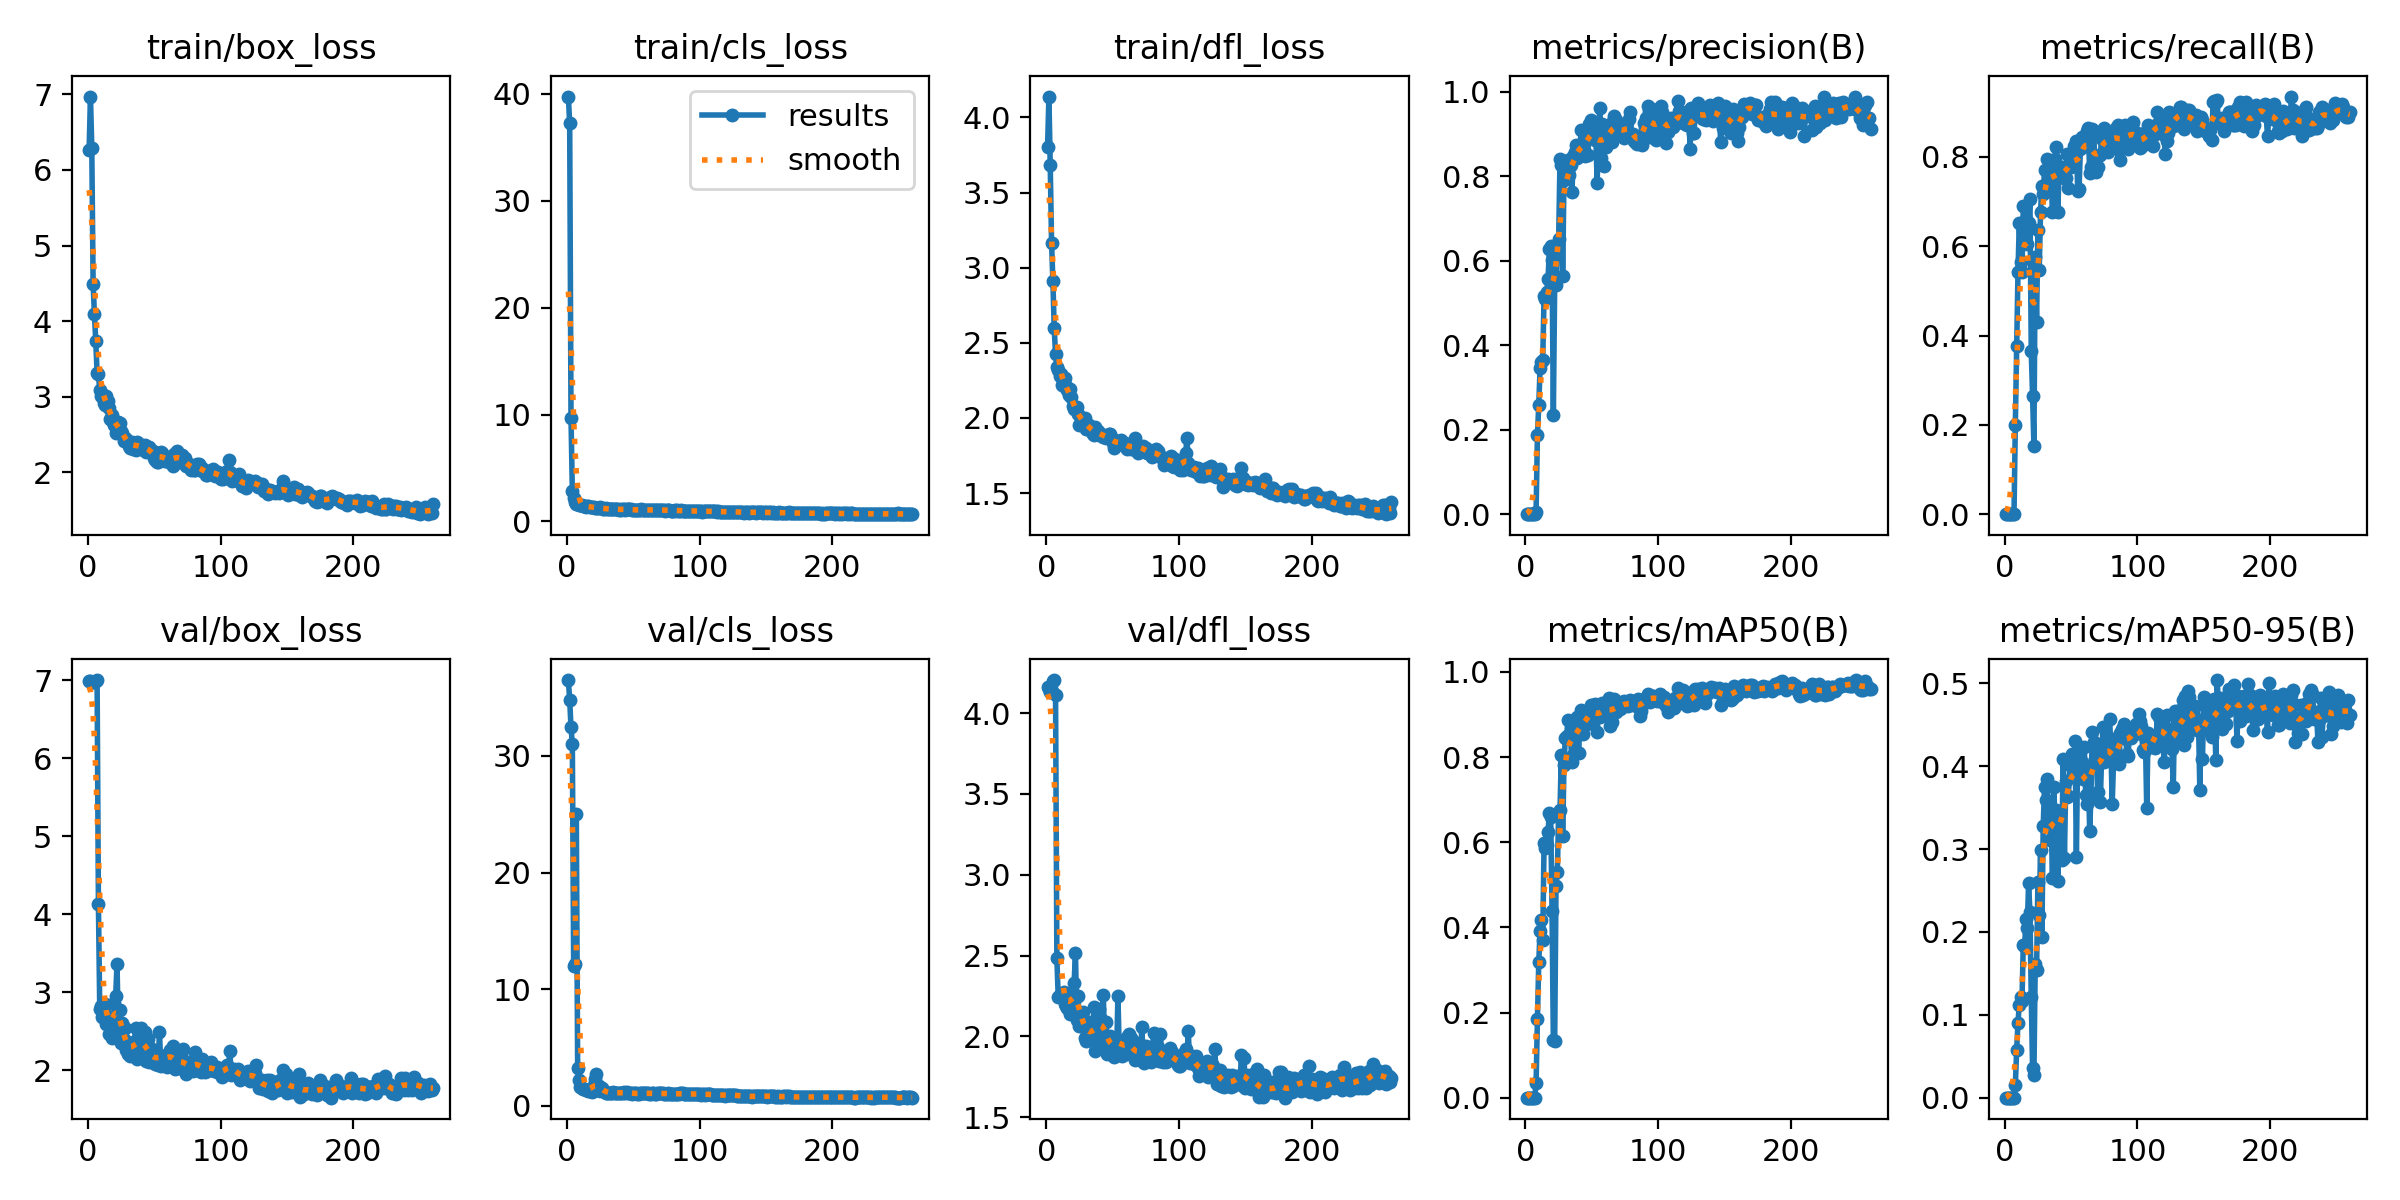

In [13]:
Image(filename=f"{HOME}\\train_model\\runs\\detect\\train\\results.png", width=1000)

In [14]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['plates']

In [15]:
from supervision.metrics import MeanAveragePrecision

model = YOLO('runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [16]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.31002247546269984
mAP 50 0.8157035846402654
mAP 75 0.18762096062593647


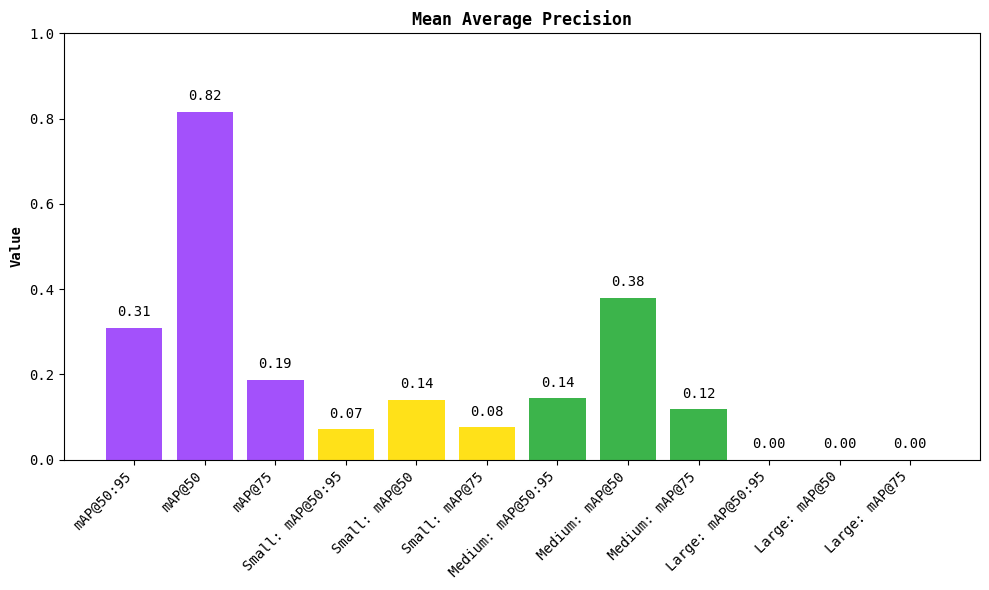

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
map.plot()
plt.show()


## Run inference with fine-tuned YOLOv12 model

In [18]:

from PIL import Image, ImageOps
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

In [19]:
def histogram_equalization(image):
    """
    ทำ Histogram Equalization บนช่อง Value (V) ของภาพ HSV
    """
    # แปลงจาก RGB เป็น HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # แยกช่อง Hue, Saturation, Value
    h, s, v = cv2.split(hsv)

    # ทำ Histogram Equalization บนช่อง V (ความสว่าง)
    v_eq = cv2.equalizeHist(v)

    # รวมกลับเป็น HSV
    hsv_eq = cv2.merge([h, s, v_eq])
    # แปลงกลับเป็น RGB
    image_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

    return image_eq

def white_balance_simple(image):
    """
    Simple white balance by scaling channels based on average intensity
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate the mean for each channel
    mean_r = np.mean(image_float[:,:,0])
    mean_g = np.mean(image_float[:,:,1])
    mean_b = np.mean(image_float[:,:,2])

    # Calculate scaling factors
    scale_r = 128 / mean_r if mean_r > 0 else 1
    scale_g = 128 / mean_g if mean_g > 0 else 1
    scale_b = 128 / mean_b if mean_b > 0 else 1

    # Scale each channel
    image_float[:,:,0] *= scale_r
    image_float[:,:,1] *= scale_g
    image_float[:,:,2] *= scale_b

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)

    return image_balanced

def white_balance_gray_world(image):
    """
    Gray World Assumption white balance method
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate average of each channel
    r_avg = np.mean(image_float[:,:,0])
    g_avg = np.mean(image_float[:,:,1])
    b_avg = np.mean(image_float[:,:,2])

    # Calculate the overall average
    avg = (r_avg + g_avg + b_avg) / 3

    # Calculate scaling factors
    r_scale = avg / r_avg if r_avg > 0 else 1
    g_scale = avg / g_avg if g_avg > 0 else 1
    b_scale = avg / b_avg if b_avg > 0 else 1

    # Apply scaling
    image_float[:,:,0] *= r_scale
    image_float[:,:,1] *= g_scale
    image_float[:,:,2] *= b_scale

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)
    return image_balanced

In [24]:
def detect_color_from_bbox(image, bbox, crop_ratio=0.8):
    """
    Detect average color from bounding box using advanced color analysis

    Args:
    - image: PIL Image
    - bbox: (xmin, ymin, xmax, ymax)
    - crop_ratio: Ratio of bounding box to analyze (default 0.8)

    Returns:
    - Tuple of (hue, saturation, value)
    """
    xmin, ymin, xmax, ymax = bbox
    cropped_img = image.crop((xmin, ymin, xmax, ymax))
    cropped_img = np.array(cropped_img)

    # Convert to HSV
    hsv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2HSV)

    # Apply median blur to reduce noise
    hsv_img = cv2.medianBlur(hsv_img, 5)

    # Crop center of the image
    h, w, _ = hsv_img.shape
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    y_offset, x_offset = (h - new_h) // 2, (w - new_w) // 2
    cropped_center = hsv_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

    # Calculate median values
    avg_hue = np.median(cropped_center[:, :, 0])
    avg_sat = np.median(cropped_center[:, :, 1])
    avg_val = np.median(cropped_center[:, :, 2])

    return avg_hue, avg_sat, avg_val

def identify_color(avg_hue, avg_sat, avg_val):
    """
    Identify color based on HSV values

    Args:
    - avg_hue: Hue value (0-180 in OpenCV)
    - avg_sat: Saturation value (0-255)
    - avg_val: Value/Brightness value (0-255)

    Returns:
    - Color name as string
    """
    # Convert OpenCV HSV to standard HSV
    hue = avg_hue * 2  # OpenCV uses 0-180, standard HSV uses 0-360
    sat = avg_sat / 255 * 100  # Convert to percentage
    val = avg_val / 255 * 100  # Convert to percentage

    # Print debug information
    print(f"🔍 Hue: {hue:.2f}, Saturation: {sat:.2f}%, Value: {val:.2f}%")

    # Check for white, black, or gray conditions
    if val < 20:
        return "Black"
    if sat < 20 or val > 90:
        return "White"

    # Detailed color mapping
    if (hue >= 330 or hue <= 30):  # Red
        return "Red"
    elif 30 < hue < 90:  # Yellow to Green
        if hue < 60:
            return "Yellow"
        else:
            return "Green"
    elif 90 <= hue < 150:  # Cyan to Blue
        if hue < 120:
            return "Cyan"
        else:
            return "Blue"
    elif 150 <= hue < 270:  # Blue to Purple
        if hue < 210:
            return "Blue"
        else:
            return "Purple"
    elif 270 <= hue < 330:  # Magenta to Red
        return "Red2"

    return "Unknown"

In [20]:
# Main processing function
def process_image(image_path, model, sv):
    # Open and preprocess image
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    #image = Image.fromarray(white_balance_gray_world(np.array(image)))

    # Detect objects
    results = model(image, verbose=False)[0]
    # ปรับค่า IoU threshold ในขั้นตอน NMS
    detections = sv.Detections.from_ultralytics(results).with_nms()


    # Annotate image
    box_annotator = sv.BoxAnnotator(thickness=1)
    label_annotator = sv.LabelAnnotator()
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Count colors
    dict_count = {}
    for i, box in enumerate(detections.xyxy):
        avg_color = detect_color_from_bbox(image, box)
        color = identify_color(*avg_color)

        # Count colors
        dict_count[color] = dict_count.get(color, 0) + 1

    # Print results
    for key, value in dict_count.items():
        print(f"{key}: {value}")

    print(f"Number of detections: {len(detections.xyxy)}")
    print(f"Number of boxes drawn: {len(detections)}")

    # Plot image
    sv.plot_image(annotated_image)

    return dict_count, annotated_image

# Call the processing function

# result_count, result_image = process_image(image_path, model, sv)

## predict model from your picture

🔍 Hue: 340.00, Saturation: 74.12%, Value: 54.51%
🔍 Hue: 346.00, Saturation: 78.82%, Value: 54.12%
🔍 Hue: 342.00, Saturation: 73.33%, Value: 52.55%
🔍 Hue: 342.00, Saturation: 74.90%, Value: 55.29%
🔍 Hue: 248.00, Saturation: 12.55%, Value: 72.55%
🔍 Hue: 30.00, Saturation: 56.47%, Value: 78.43%
🔍 Hue: 348.00, Saturation: 77.65%, Value: 54.12%
🔍 Hue: 232.00, Saturation: 23.14%, Value: 15.69%
Red: 6
White: 1
Black: 1
Number of detections: 8
Number of boxes drawn: 8


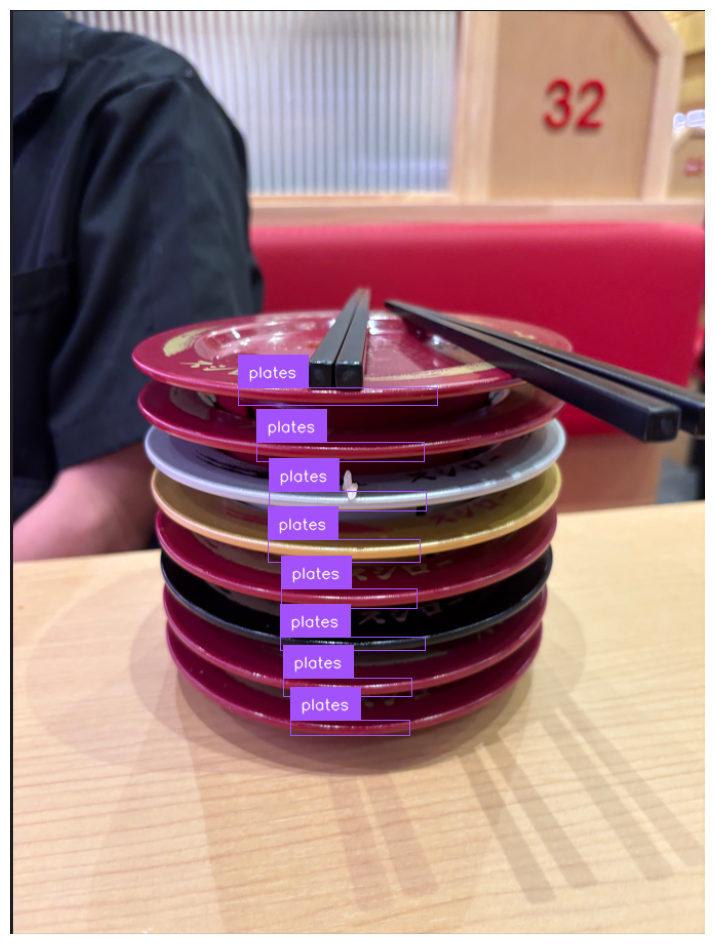

In [25]:
#select your picture to predict
image_path = "../Sample_plates.png"
result_count, result_image = process_image(image_path, model, sv)

## predict model from dataset test

🔍 Hue: 72.00, Saturation: 3.92%, Value: 83.53%
🔍 Hue: 48.00, Saturation: 4.71%, Value: 75.69%
🔍 Hue: 28.00, Saturation: 12.16%, Value: 69.02%
🔍 Hue: 40.00, Saturation: 5.88%, Value: 74.90%
🔍 Hue: 354.00, Saturation: 76.08%, Value: 49.80%
🔍 Hue: 354.00, Saturation: 78.82%, Value: 49.02%
🔍 Hue: 22.00, Saturation: 16.08%, Value: 63.53%
🔍 Hue: 38.00, Saturation: 6.27%, Value: 80.00%
🔍 Hue: 2.00, Saturation: 70.98%, Value: 53.33%
🔍 Hue: 356.00, Saturation: 74.90%, Value: 37.65%
🔍 Hue: 354.00, Saturation: 70.59%, Value: 54.51%
🔍 Hue: 356.00, Saturation: 74.90%, Value: 52.16%
🔍 Hue: 352.00, Saturation: 78.04%, Value: 40.39%
🔍 Hue: 2.00, Saturation: 74.31%, Value: 46.67%
🔍 Hue: 354.00, Saturation: 77.84%, Value: 47.06%
🔍 Hue: 354.00, Saturation: 69.80%, Value: 58.43%
White: 6
Red: 10
Number of detections: 16
Number of boxes drawn: 16


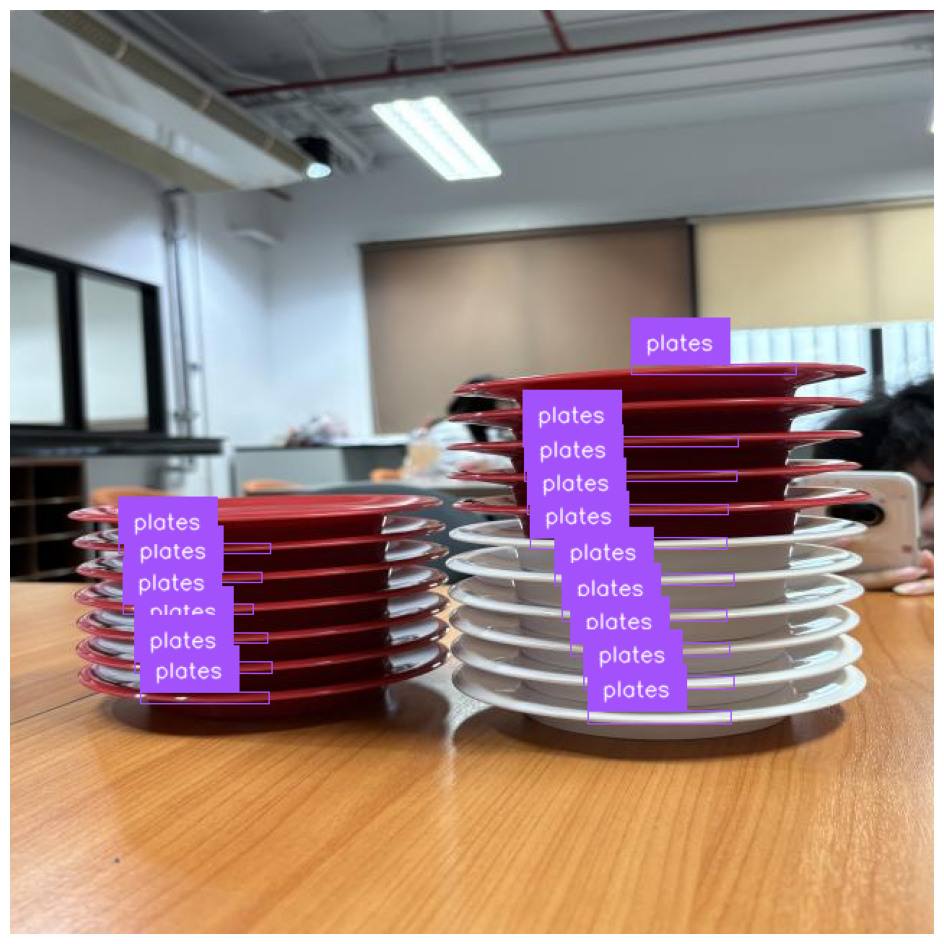

In [30]:
i = random.randint(0, len(ds))

image_path, image, target = ds[i]

result_count, result_image = process_image(image_path, model, sv)

# Calculate MAE from test dataset

In [32]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# calculate from how many real plates and predicted plates

def calculate_mae(real_count, predicted_count):
    """
    Calculate Mean Absolute Error (MAE) between real and predicted counts.

    Args:
    - real_count: Dictionary of real counts
    - predicted_count: Dictionary of predicted counts

    Returns:
    - MAE value
    """
    # Create a set of all unique colors
    all_colors = set(real_count.keys()).union(set(predicted_count.keys()))

    # Create arrays for real and predicted counts
    real_counts = np.array([real_count.get(color, 0) for color in all_colors])
    predicted_counts = np.array([predicted_count.get(color, 0) for color in all_colors])

    # Calculate MAE
    mae = mean_absolute_error(real_counts, predicted_counts)
    
    return mae

In [ ]:
# Example usage
real_count = {
    "Red": 2,
    "Green": 1,
    "Blue": 0,
    "Yellow": 1
}


